<a href="https://colab.research.google.com/github/JunyiJ/VAEs/blob/master/AutoEncoder_and_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **0. Load Preliminary Functions**

Code adopted from course https://github.com/mit-6s978/mit-6s978.github.io

# a. Import Libraries and Functions

In [1]:
import torch
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
device

device(type='cuda')

# b. MNIST Data Loader

In [3]:
tensor_transform = transforms.ToTensor()

batch_size = 100
MNIST_dataset = datasets.MNIST(root = "./data",
									train = True,
									download = True,
									transform = tensor_transform)

MNIST_loader = torch.utils.data.DataLoader(dataset = MNIST_dataset,
							   batch_size = batch_size,
								 shuffle = True)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:10<00:00, 902kB/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 135kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.90MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# c. Training Function

In [4]:
from math import e
mse = torch.nn.MSELoss()

def loss_func(model, x, reg_func=None, coeff=1e-3):
    output = model(x)
    recon_loss = torch.nn.functional.binary_cross_entropy(output['imgs'], x, reduction='sum')

    if reg_func is not None:
      reg = reg_func(output)
      reg = reg.sum()
    else:
      reg = 0.0
    return recon_loss + coeff * reg, recon_loss,  reg

def train(dataloader, model, loss_func, optimizer, epochs):
    losses = []

    for epoch in tqdm(range(epochs), desc='Epochs'):
        running_loss = 0.0
        running_reconstruct_loss = 0.0
        running_kl_loss = 0.0
        batch_progress = tqdm(dataloader, desc='Batches', leave=False)

        for iter, (images, labels) in enumerate(batch_progress):
            batch_size = images.shape[0]
            images = images.reshape(batch_size, -1).to(device)
            loss, reconstruct_loss, kl_loss = loss_func(model, images)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            running_reconstruct_loss += reconstruct_loss.item()
            running_kl_loss += kl_loss.item()
            avg_loss = running_loss / len(MNIST_dataset) * batch_size
            avg_reconstruct_loss = running_reconstruct_loss / len(MNIST_dataset) * batch_size
            avg_kl_loss = running_kl_loss / len(MNIST_dataset) * batch_size
            losses.append(loss.item())

        tqdm.write(f'----\nEpoch [{epoch+1}/{epochs}], Average Loss: {avg_loss:.4f}\nAverage Reconstrut Loss: {avg_reconstruct_loss:.4f}\nAverage KL loss: {avg_kl_loss:.8f}\n')

    return losses


# d. Evaluation Function

In [5]:
def plot_latent_images(model, n, digit_size=28):
    grid_x = np.linspace(-2, 2, n)
    grid_y = np.linspace(-2, 2, n)

    image_width = digit_size * n
    image_height = digit_size * n
    image = np.zeros((image_height, image_width))

    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z = torch.tensor([[xi, yi]], dtype=torch.float32).to(device)
            with torch.no_grad():
                x_decoded = model.decode(z)
            digit = x_decoded.view(digit_size, digit_size).cpu().numpy()
            image[i * digit_size: (i + 1) * digit_size,
                  j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='Greys_r')
    plt.axis('Off')
    plt.show()


def eval(model):
    original_imgs = torch.cat([MNIST_dataset[i][0] for i in range(5)])
    with torch.no_grad():
      res = model(original_imgs.reshape(5, -1).to(device))
      reconstructed_imgs = res['imgs']
      reconstructed_imgs = reconstructed_imgs.cpu().reshape(*original_imgs.shape)

    fig, axes = plt.subplots(5, 2, figsize=(10, 25))

    for i in range(5):
        original_image = original_imgs[i].reshape(28, 28)
        axes[i, 0].imshow(original_image, cmap='gray')
        axes[i, 0].set_title(f'Original Image {i+1}')
        axes[i, 0].axis('off')

        reconstructed_image = reconstructed_imgs[i].reshape(28, 28)
        axes[i, 1].imshow(reconstructed_image, cmap='gray')
        axes[i, 1].set_title(f'Reconstructed Image {i+1}')
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()


# **1. AutoEncoder (AE)**

## a. Model


In [6]:
class AE(torch.nn.Module):
    def __init__(self, input_dim, hidden_dims):
        super().__init__()

        assert hidden_dims[-1] == 2, "always use 2 as the latent dimension for generating a 2D image grid during evaluation"

        encoder_layers = []
        for in_dim, out_dim in zip([input_dim] + hidden_dims[:-1], hidden_dims):
          encoder_layers.append(torch.nn.Linear(in_dim, out_dim))
          encoder_layers.append(torch.nn.ReLU())
        self.encoder = torch.nn.Sequential(*encoder_layers)
        decoder_layers = []
        for index in range(len(hidden_dims)-1, 0, -1):
          in_dim = hidden_dims[index]
          out_dim = hidden_dims[index-1]
          decoder_layers.append(torch.nn.Linear(in_dim, out_dim))
          decoder_layers.append(torch.nn.ReLU())
        decoder_layers.append(torch.nn.Linear(hidden_dims[0], input_dim))
        decoder_layers.append(torch.nn.Sigmoid())
        self.decoder = torch.nn.Sequential(*decoder_layers)


    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decode(encoded)
        return {"imgs": decoded}

### Test
hidden_dims = [128, 64, 36, 18, 2]
input_dim = 256
test_tensor = torch.randn([1, input_dim]).to(device)

ae_test = AE(input_dim, hidden_dims).to(device)

with torch.no_grad():
  test_out = ae_test(test_tensor)


## b. Loss Functions and Optimizers


In [7]:
def loss_AE(model, x):
    reconstructed = model(x)['imgs']
    loss = torch.nn.functional.binary_cross_entropy(reconstructed, x, reduction='sum')
    return loss, loss, loss-loss

image_shape = MNIST_dataset[0][0].shape
input_dim = torch.prod(torch.tensor(image_shape)).item()
print("input_dim: ", input_dim)

hidden_dims = [256, 32, 16, 2]

ae = AE(input_dim, hidden_dims).to(device)
print(ae)

optimizer_ae = torch.optim.Adam(ae.parameters(),
                                lr = 1e-3,
                                weight_decay = 1e-8)


input_dim:  784
AE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=16, bias=True)
    (5): ReLU()
    (6): Linear(in_features=16, out_features=2, bias=True)
    (7): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=784, bias=True)
    (7): Sigmoid()
  )
)


## c. Training


In [8]:
#@title Train AE
epochs = 20

log_ae = train(MNIST_loader, ae, loss_AE, optimizer_ae, epochs)


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [1/20], Average Loss: 19883.9794
Average Reconstrut Loss: 19883.9794
Average KL loss: 0.00000000



Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [2/20], Average Loss: 16500.1536
Average Reconstrut Loss: 16500.1536
Average KL loss: 0.00000000



Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [3/20], Average Loss: 15781.4536
Average Reconstrut Loss: 15781.4536
Average KL loss: 0.00000000



Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [4/20], Average Loss: 15377.9090
Average Reconstrut Loss: 15377.9090
Average KL loss: 0.00000000



Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [5/20], Average Loss: 15037.4259
Average Reconstrut Loss: 15037.4259
Average KL loss: 0.00000000



Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [6/20], Average Loss: 14802.5198
Average Reconstrut Loss: 14802.5198
Average KL loss: 0.00000000



Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [7/20], Average Loss: 14662.7715
Average Reconstrut Loss: 14662.7715
Average KL loss: 0.00000000



Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [8/20], Average Loss: 14538.3040
Average Reconstrut Loss: 14538.3040
Average KL loss: 0.00000000



Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [9/20], Average Loss: 14404.2289
Average Reconstrut Loss: 14404.2289
Average KL loss: 0.00000000



Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [10/20], Average Loss: 14295.2932
Average Reconstrut Loss: 14295.2932
Average KL loss: 0.00000000



Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [11/20], Average Loss: 14247.6935
Average Reconstrut Loss: 14247.6935
Average KL loss: 0.00000000



Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [12/20], Average Loss: 14135.8441
Average Reconstrut Loss: 14135.8441
Average KL loss: 0.00000000



Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [13/20], Average Loss: 14132.1220
Average Reconstrut Loss: 14132.1220
Average KL loss: 0.00000000



Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [14/20], Average Loss: 14029.9140
Average Reconstrut Loss: 14029.9140
Average KL loss: 0.00000000



Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [15/20], Average Loss: 13983.8771
Average Reconstrut Loss: 13983.8771
Average KL loss: 0.00000000



Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [16/20], Average Loss: 13941.0483
Average Reconstrut Loss: 13941.0483
Average KL loss: 0.00000000



Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [17/20], Average Loss: 13933.8221
Average Reconstrut Loss: 13933.8221
Average KL loss: 0.00000000



Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [18/20], Average Loss: 13843.8656
Average Reconstrut Loss: 13843.8656
Average KL loss: 0.00000000



Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [19/20], Average Loss: 13957.0505
Average Reconstrut Loss: 13957.0505
Average KL loss: 0.00000000



Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [20/20], Average Loss: 13938.2673
Average Reconstrut Loss: 13938.2673
Average KL loss: 0.00000000



## d. Evaluation


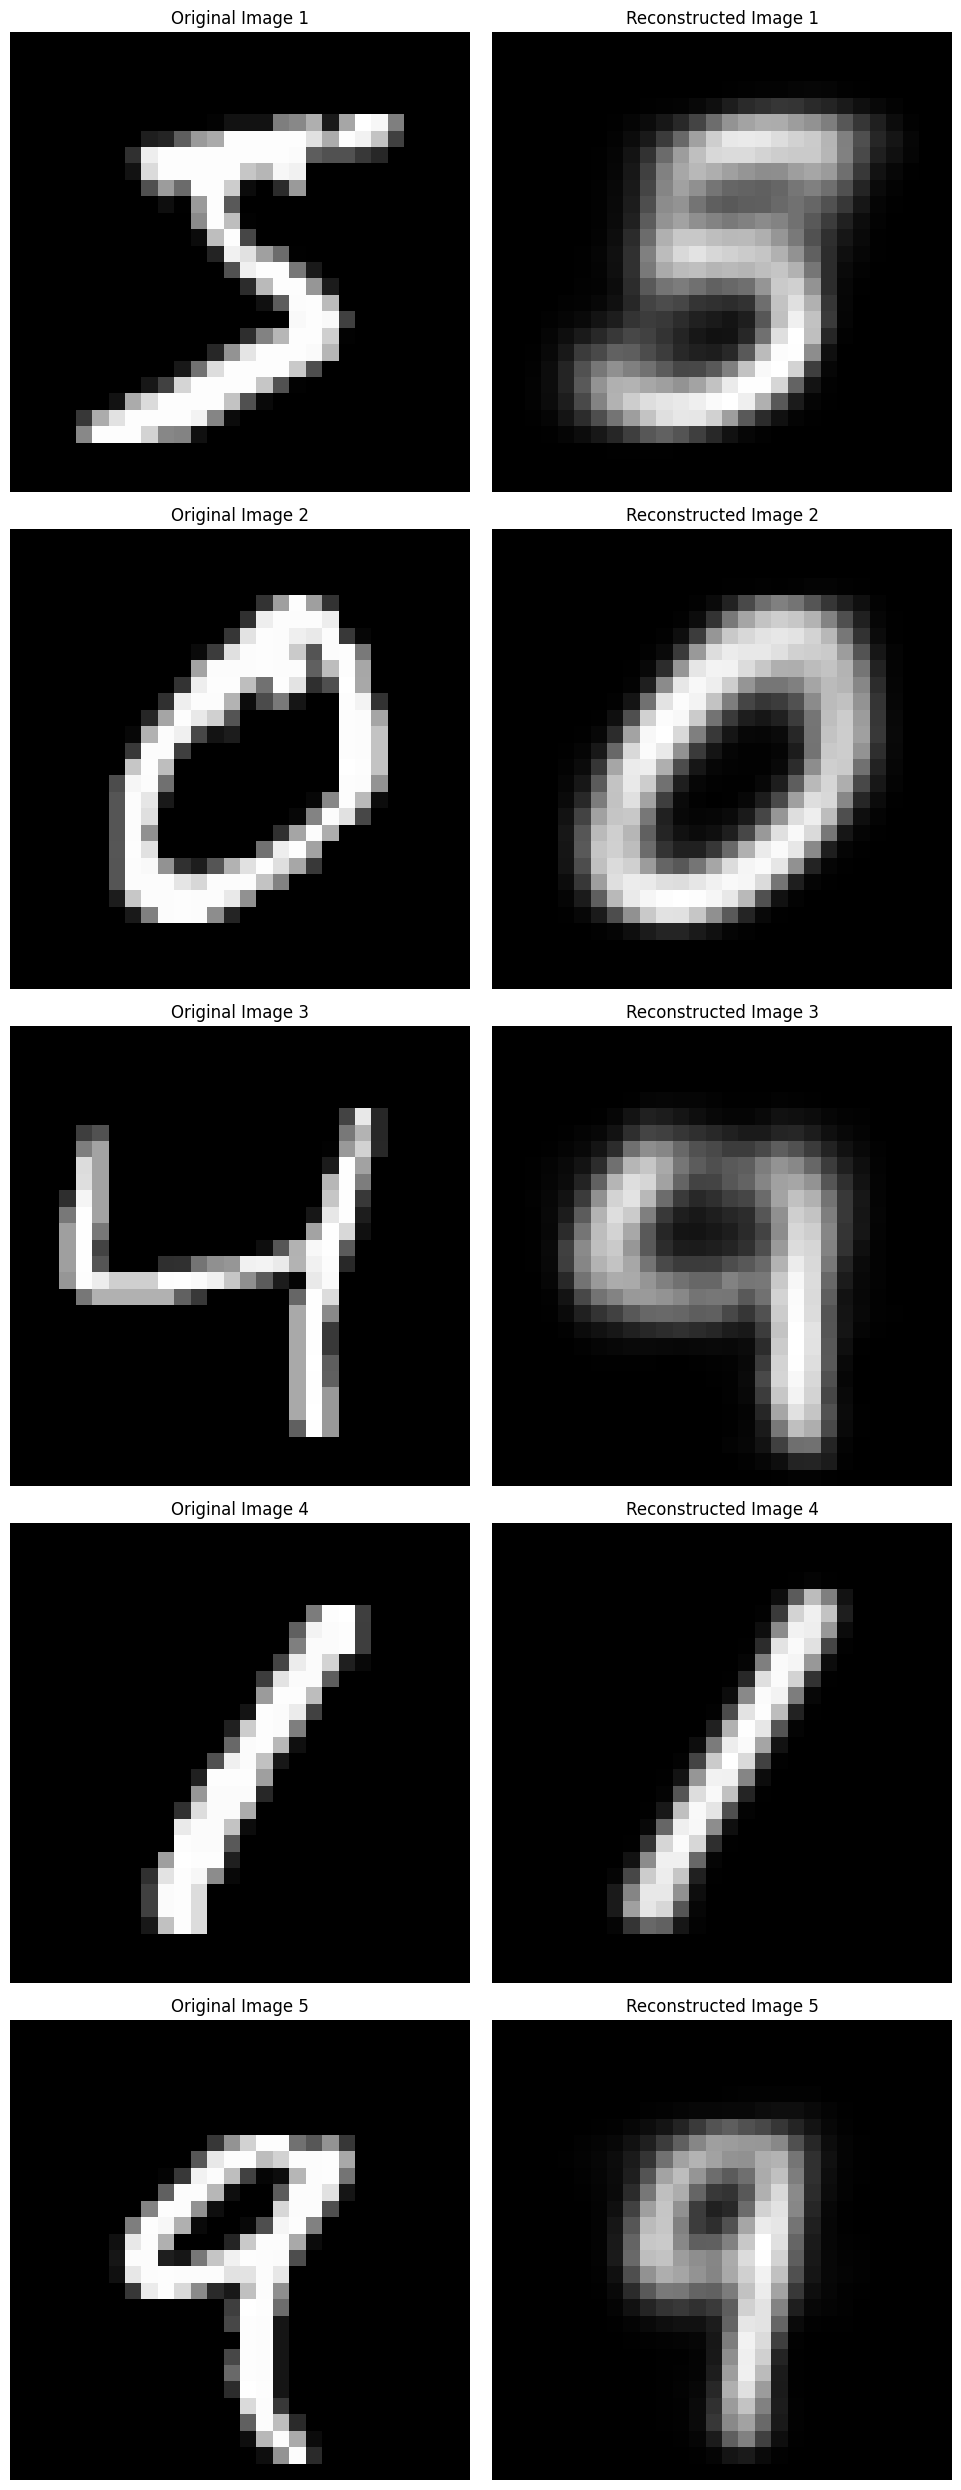

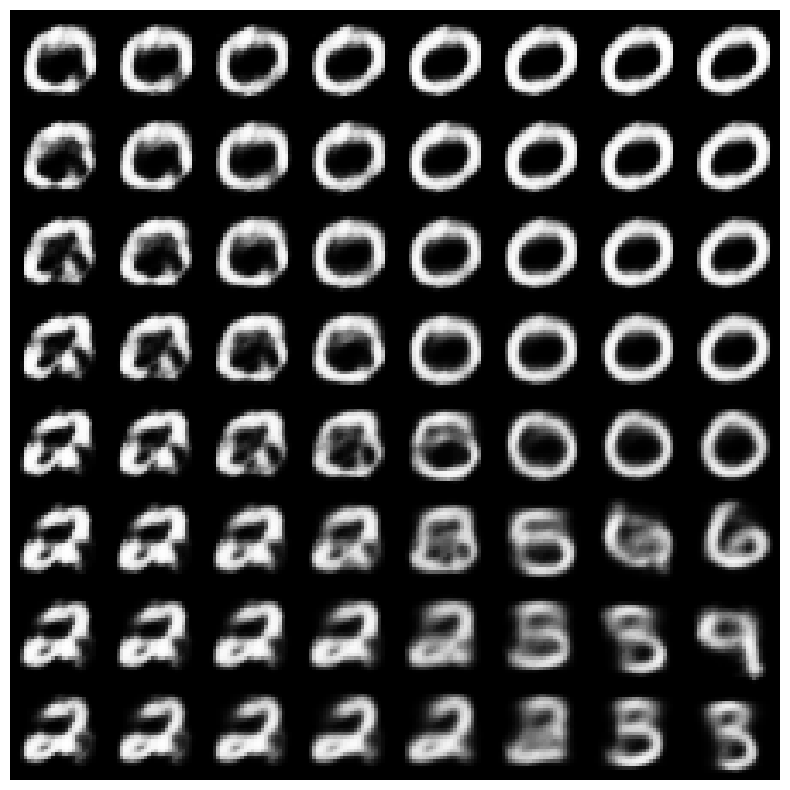

In [9]:
##################
#@title Evaluate AE
eval(ae)
plot_latent_images(ae, n=8)
##################


# **2. Variational  AutoEncoder (VAE)**
## a. Model

In [10]:
class VAE(torch.nn.Module):
  def __init__(self, input_dim, hidden_dims, decode_dim=-1, use_sigmoid=True):
      '''
      input_dim: The dimensionality of the input data.
      hidden_dims: A list of hidden dimensions for the layers of the encoder and decoder.
      decode_dim: (Optional) Specifies the dimensions to decode, if different from input_dim.
      '''
      super().__init__()

      self.z_size = hidden_dims[-1] // 2
      assert(self.z_size * 2 == hidden_dims[-1]), "Last hidden layer size should be dividable by 2"
      encoder_layers = []
      for in_dim, out_dim in zip([input_dim] + hidden_dims[:-1], hidden_dims):
        encoder_layers.append(torch.nn.Linear(in_dim, out_dim))
        encoder_layers.append(torch.nn.LeakyReLU(0.1))
      self.encoder = torch.nn.Sequential(*encoder_layers)
      decoder_layers = []
      decoder_layers.append(torch.nn.Linear(self.z_size, hidden_dims[-1]))
      decoder_layers.append(torch.nn.LeakyReLU(0.1))
      first_dim = hidden_dims[0]
      for index in range(len(hidden_dims)-1, 0, -1):
        in_dim = hidden_dims[index]
        out_dim = hidden_dims[index-1]
        decoder_layers.append(torch.nn.Linear(in_dim, out_dim))
        decoder_layers.append(torch.nn.LeakyReLU(0.1))
      decoder_layers.append(torch.nn.Linear(first_dim, decode_dim if decode_dim > 0 else input_dim))
      if use_sigmoid:
        decoder_layers.append(torch.nn.Sigmoid())
      self.decoder = torch.nn.Sequential(*decoder_layers)

  def encode(self, x):
      mean, logvar = torch.split(self.encoder(x), split_size_or_sections=[self.z_size, self.z_size], dim=-1)
      return mean, logvar

  def reparameterize(self, mean, logvar, n_samples_per_z=1):
      bn, latent_dim = mean.shape
      assert n_samples_per_z > 0, "n_samples_per_z should be larger than 0"
      epsilon = torch.randn_like(logvar).to(device)
      std = torch.exp(logvar * 0.5)
      z = mean + std * epsilon
      return z

  def decode(self, z):
      probs = self.decoder(z)
      return probs

  def forward(self, x, n_samples_per_z=1):
      mean, logvar = self.encode(x)

      batch_size, latent_dim = mean.shape
      if n_samples_per_z > 1:
        mean = mean.unsqueeze(1).expand(batch_size, n_samples_per_z, latent_dim)
        logvar = logvar.unsqueeze(1).expand(batch_size, n_samples_per_z, latent_dim)

        mean = mean.contiguous().view(batch_size * n_samples_per_z, latent_dim)
        logvar = logvar.contiguous().view(batch_size * n_samples_per_z, latent_dim)

      z = self.reparameterize(mean, logvar, n_samples_per_z)

      x_probs = self.decode(z)

      x_probs = x_probs.reshape(batch_size, n_samples_per_z, -1)
      x_probs = torch.mean(x_probs, dim=[1])

      return {
          "imgs": x_probs,
          "z": z,
          "mean": mean,
          "logvar": logvar
      }

### Test
hidden_dims = [128, 64, 36, 18, 18]
input_dim = 256
test_tensor = torch.randn([1, input_dim]).to(device)

vae_test = VAE(input_dim, hidden_dims).to(device)

with torch.no_grad():
  print(test_tensor.shape)
  test_out = vae_test(test_tensor)


torch.Size([1, 256])


## b. Loss Functions

### Loss 1: Stoachastic Gradient Variational Bayes (SGVB) Estimator

VAEs are trained by maximizing the Evidence Lower Bound (ELBO) on the marginal log-likelihood:
$$\log p(x) \geq \mathbb{E}_{q(z|x)}[\log\frac{p(x, z)}{q(z|x)}] = \mathrm{ELBO},$$

where $x$ is the data (binary images for MNIST) and $z$ is the latent code.

In practice, the above expectation is estimated using Monte Carlo sampling, yielding the generic Stoachastic Gradient Variational Bayes (SGVB) estimator,
$$\mathrm{ELBO} \approx \sum_{i, j} [\log p(x_i|z_{i, j}) + \log p(z_{i, j}) - \log q(z_{i, j}|x_i)], $$
where $z_{i, j}$ is sampled from $ q(z|x_i) = \mathcal{N}(z;\mu_i, \sigma^2_i \mathbf{I})$. In this assignment, we only sample one $z_{i,j}$ for each $x_i$ (see the function ``reparameterize()`` in the ``VAE()`` class).

In [11]:
##### Loss 1: SGVB #####
log2pi = torch.log(2.0 * torch.tensor(np.pi)).to(device)
torch_zero = torch.tensor(0.0).to(device)

def log_normal_pdf(sample, mean, logvar, raxis=1):
    ##################
    ### Problem 2(d): finish the implementation for the log-probability for normal distribution with mean and var
    ##################
    var = torch.exp(logvar)
    return -0.5 * log2pi - 0.5 * torch.log(var) - 0.5* (sample - mean)**2 / var

def loss_SGVB(output):
    logpz = log_normal_pdf(output['z'], torch_zero, torch_zero)
    logqz_x = log_normal_pdf(output['z'], output['mean'], output['logvar'])
    return -logpz + logqz_x


### Loss 2: KL Divergence w/o Estimation
In many cases, Monte Carlo sampling is not necessary to estimate all the terms of ELBO, as some terms can be integrated analytically. In the assignment, you derived the cases where the ELBO can be expressed as an analytical KL-divergence plus the expected reconstruction error, specifically when both $q(z|x)$ and $p(z)$ are Gaussian distributions:
$$\mathrm{ELBO} ≈ -D_{KL}(q(z|x) || p(z)) + \sum_{i, j} \log p(x_i|z_{i, j}) = \\\frac{1}{2}\sum_{d}(1+\log((\sigma_d)^2) - (\mu_d)^2 - (\sigma_d)^2) + \sum_{i, j} \log p(x_i|z_{i, j})$$

In [12]:
##### Loss 2: KL w/o Estimation #####
def loss_KL_wo_E(output):
    var = torch.exp(output['logvar'])
    logvar = output['logvar']
    mean = output['mean']

    return 0.5 * torch.sum(torch.pow(mean, 2)
                            + var - 1.0 - logvar,
                            dim=[1])


## c. Verifying loss 1 == loss 2


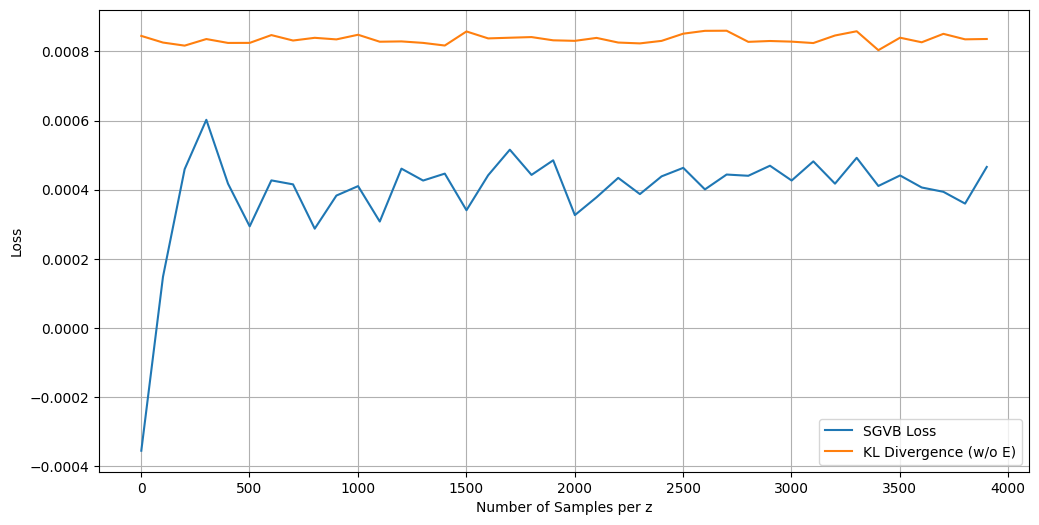

In [13]:
##################
#@title Check if the analytical KL divergence matches the Monte Carlo estimate.
hidden_dims = [128, 32, 16, 4]
image_shape = MNIST_dataset[0][0].shape
input_dim = torch.prod(torch.tensor(image_shape)).item()
vae_test = VAE(input_dim, hidden_dims).to(device)

all_l_sgvb, all_KL_wo_E = [], []
all_n_samples_per_z = list(range(1, 4000, 100))

with torch.no_grad():
    for n_samples_per_z in all_n_samples_per_z:
        for _, (imgs, _) in enumerate(MNIST_loader):
            batch_size = imgs.shape[0]
            imgs = imgs.reshape(batch_size, -1).to(device)

            output = vae_test(imgs, n_samples_per_z=n_samples_per_z)

            l_sgvb = torch.mean(loss_SGVB(output))
            l_KL_wo_E = torch.mean(loss_KL_wo_E(output))

            all_l_sgvb.append(l_sgvb.item())
            all_KL_wo_E.append(l_KL_wo_E.item())
            break

# Plot the two curves
plt.figure(figsize=(12, 6))

plt.plot(all_n_samples_per_z, all_l_sgvb, label='SGVB Loss')
plt.plot(all_n_samples_per_z, all_KL_wo_E, label='KL Divergence (w/o E)')

plt.xlabel('Number of Samples per z')
plt.ylabel('Loss')
plt.legend()

plt.grid(True)
plt.show()
##################


## d. Training with ELBO loss



In [14]:
##################
###  Train VAE with ELBO loss
epochs = 20

hidden_dims = [256, 128, 32, 16, 4]
assert hidden_dims[-1] == 4, "always use 4 as the latent dimension for generating a 2D image grid during evaluation"

image_shape = MNIST_dataset[0][0].shape
input_dim = torch.prod(torch.tensor(image_shape)).item()
print("input_dim: ", input_dim)

vae_sgvb = VAE(input_dim, hidden_dims).to(device)
print(vae_sgvb)

optimizer_vae_sgvb = torch.optim.Adam(vae_sgvb.parameters(),
                                lr = 1e-4,
                                weight_decay = 1e-8)

log_vae_sgvb = train(MNIST_loader, vae_sgvb, lambda model, x: loss_func(model, x, reg_func=loss_SGVB, coeff=1), optimizer_vae_sgvb, epochs)
##################


input_dim:  784
VAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.1)
    (4): Linear(in_features=128, out_features=32, bias=True)
    (5): LeakyReLU(negative_slope=0.1)
    (6): Linear(in_features=32, out_features=16, bias=True)
    (7): LeakyReLU(negative_slope=0.1)
    (8): Linear(in_features=16, out_features=4, bias=True)
    (9): LeakyReLU(negative_slope=0.1)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=4, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Linear(in_features=4, out_features=16, bias=True)
    (3): LeakyReLU(negative_slope=0.1)
    (4): Linear(in_features=16, out_features=32, bias=True)
    (5): LeakyReLU(negative_slope=0.1)
    (6): Linear(in_features=32, out_features=128, bias=True)
    (7): LeakyReLU(negative_slope=0.1)
    (8): Linear(in_features=128,

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [1/20], Average Loss: 27105.5475
Average Reconstrut Loss: 26613.0850
Average KL loss: 492.46246351



Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [2/20], Average Loss: 20329.5449
Average Reconstrut Loss: 20147.8959
Average KL loss: 181.64896731



Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [3/20], Average Loss: 19555.0759
Average Reconstrut Loss: 19353.2254
Average KL loss: 201.85042379



Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [4/20], Average Loss: 19164.8308
Average Reconstrut Loss: 18943.7333
Average KL loss: 221.09755796



Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [5/20], Average Loss: 18942.1764
Average Reconstrut Loss: 18707.8738
Average KL loss: 234.30256348



Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [6/20], Average Loss: 18823.8819
Average Reconstrut Loss: 18587.3042
Average KL loss: 236.57774277



Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [7/20], Average Loss: 18751.3903
Average Reconstrut Loss: 18513.2773
Average KL loss: 238.11297610



Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [8/20], Average Loss: 18689.9355
Average Reconstrut Loss: 18448.4249
Average KL loss: 241.51060237



Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [9/20], Average Loss: 18602.1054
Average Reconstrut Loss: 18354.7679
Average KL loss: 247.33748301



Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [10/20], Average Loss: 18455.4504
Average Reconstrut Loss: 18199.9006
Average KL loss: 255.54980736



Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [11/20], Average Loss: 18299.5627
Average Reconstrut Loss: 18033.7978
Average KL loss: 265.76487114



Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [12/20], Average Loss: 18205.9319
Average Reconstrut Loss: 17934.7658
Average KL loss: 271.16601143



Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [13/20], Average Loss: 18134.7072
Average Reconstrut Loss: 17854.7685
Average KL loss: 279.93872093



Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [14/20], Average Loss: 18084.5547
Average Reconstrut Loss: 17799.9284
Average KL loss: 284.62622826



Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [15/20], Average Loss: 18038.3749
Average Reconstrut Loss: 17749.2954
Average KL loss: 289.07949684



Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [16/20], Average Loss: 17997.1603
Average Reconstrut Loss: 17703.4092
Average KL loss: 293.75118230



Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [17/20], Average Loss: 17954.4821
Average Reconstrut Loss: 17656.5815
Average KL loss: 297.90065509



Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [18/20], Average Loss: 17909.0011
Average Reconstrut Loss: 17605.5054
Average KL loss: 303.49573555



Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [19/20], Average Loss: 17865.2406
Average Reconstrut Loss: 17557.5263
Average KL loss: 307.71432462



Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [20/20], Average Loss: 17821.0262
Average Reconstrut Loss: 17507.4151
Average KL loss: 313.61103139



## e. Evaluation

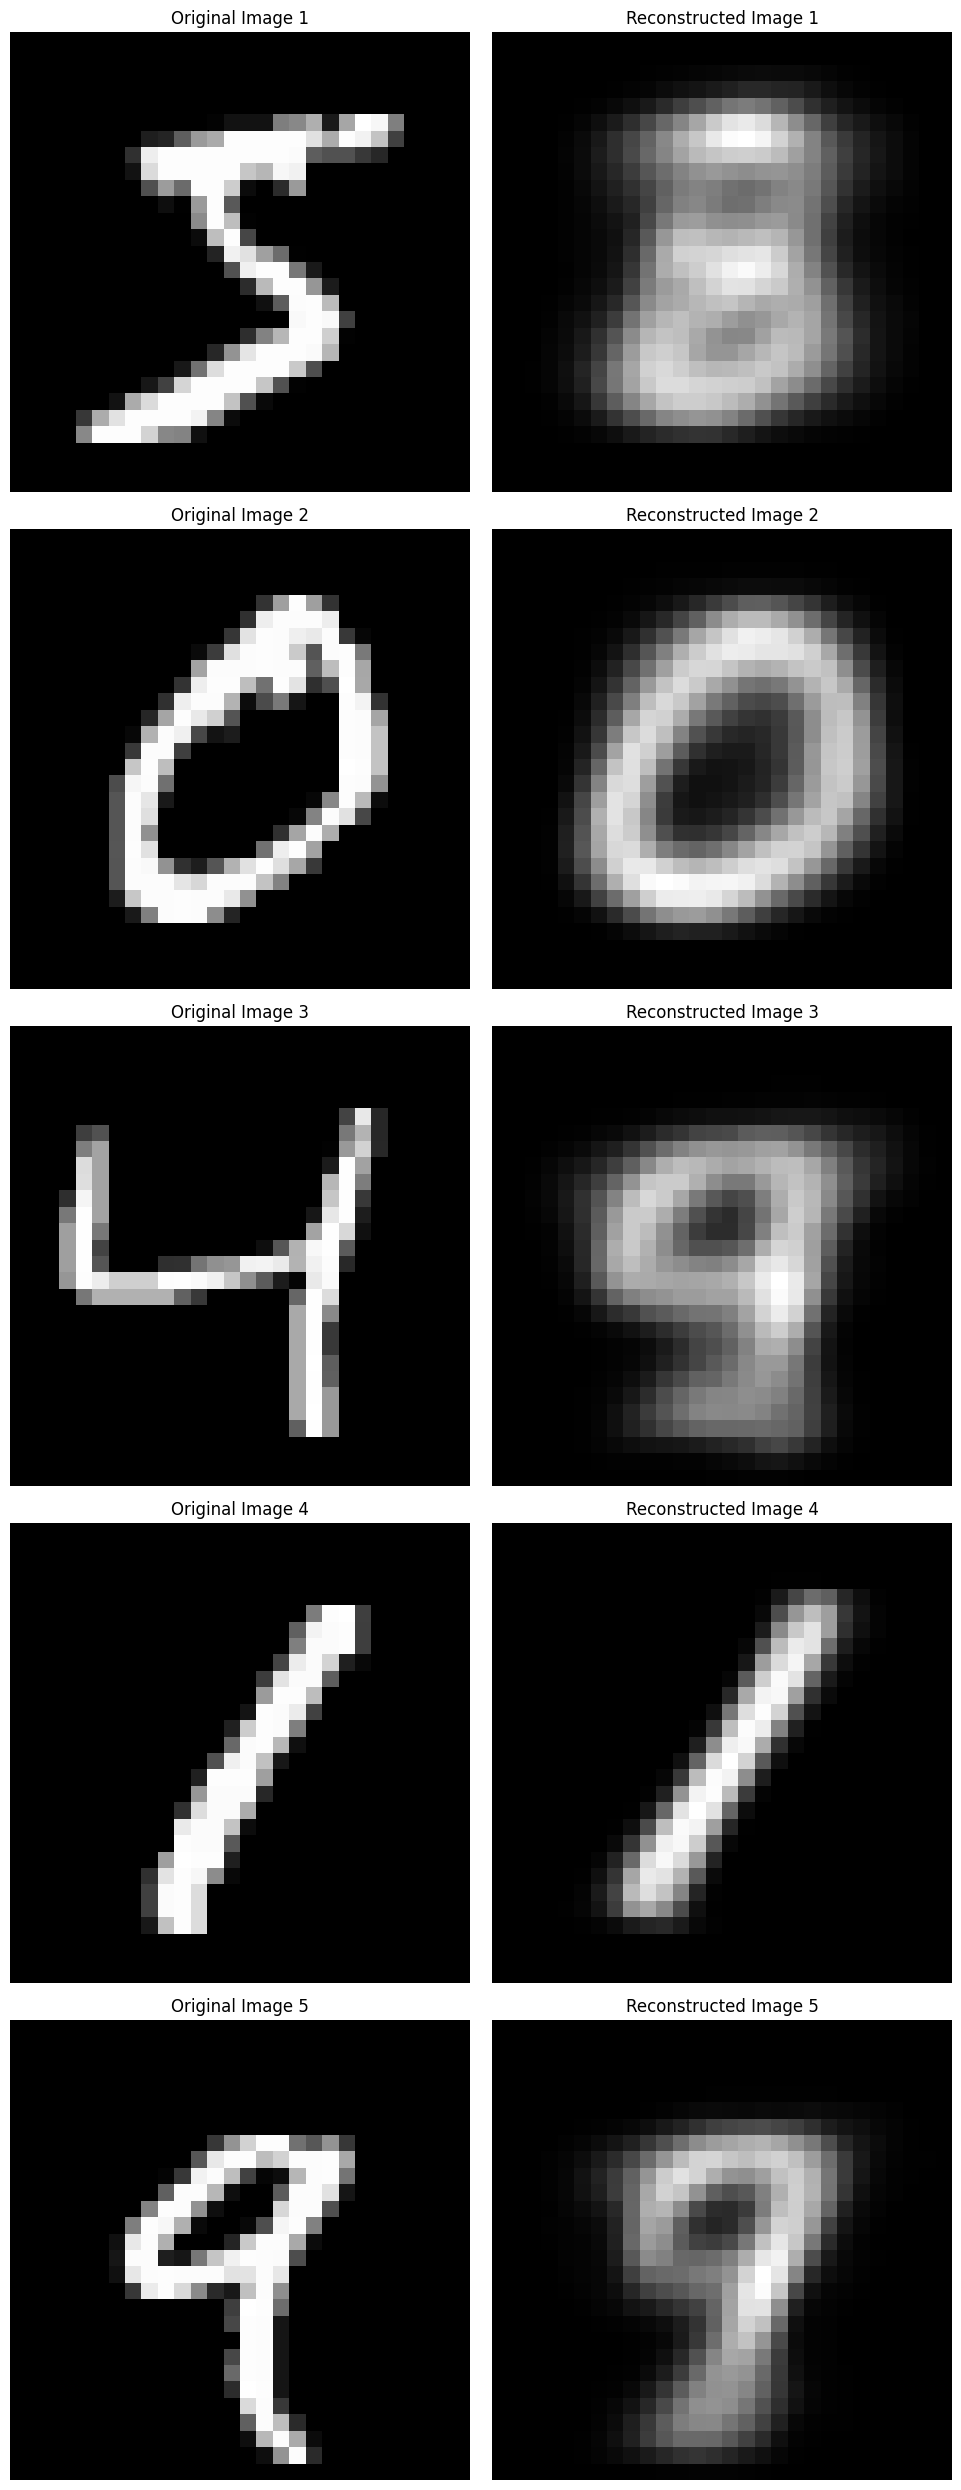

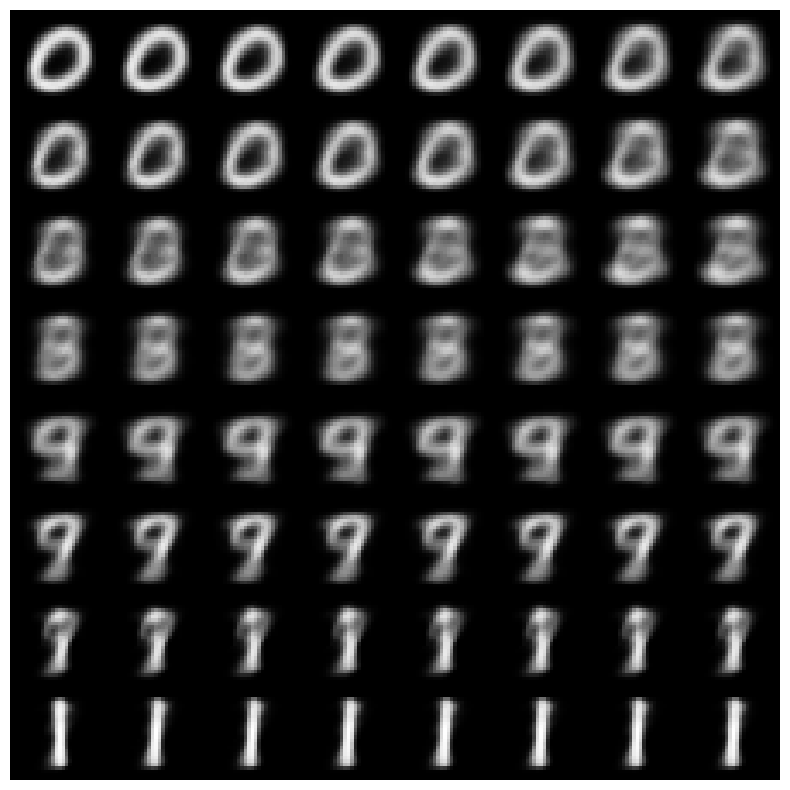

In [15]:
##################
### Problem 3(c): Evaluate VAE with ELBO loss
eval(vae_sgvb)
plot_latent_images(vae_sgvb, n=8)
##################


## f. Training with KL Divergence w/o Estimation

In [16]:
##################
#@title Train VAE with analytical KL
epochs = 20

hidden_dims = [400, 4]
# assert hidden_dims[-1] == 4, "always use 4 as the latent dimension for generating a 2D image grid during evaluation"

image_shape = MNIST_dataset[0][0].shape
input_dim = torch.prod(torch.tensor(image_shape)).item()
print("input_dim: ", input_dim)

vae_kl_wo_e = VAE(input_dim, hidden_dims).to(device)
print(vae_kl_wo_e)

optimizer_vae_kl_wo_e = torch.optim.Adam(vae_kl_wo_e.parameters(),
                                lr = 1e-3,
                                weight_decay = 1e-8)

log_vae_kl_wo_e = train(MNIST_loader, vae_kl_wo_e, lambda model, x: loss_func(model, x, reg_func=loss_KL_wo_E, coeff=1), optimizer_vae_kl_wo_e, epochs)
##################


input_dim:  784
VAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=400, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Linear(in_features=400, out_features=4, bias=True)
    (3): LeakyReLU(negative_slope=0.1)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=4, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Linear(in_features=4, out_features=400, bias=True)
    (3): LeakyReLU(negative_slope=0.1)
    (4): Linear(in_features=400, out_features=784, bias=True)
    (5): Sigmoid()
  )
)


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [1/20], Average Loss: 19531.9108
Average Reconstrut Loss: 19074.0121
Average KL loss: 457.89867276



Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [2/20], Average Loss: 17071.5619
Average Reconstrut Loss: 16555.0813
Average KL loss: 516.48061300



Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [3/20], Average Loss: 16651.4294
Average Reconstrut Loss: 16113.1184
Average KL loss: 538.31099859



Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [4/20], Average Loss: 16388.8249
Average Reconstrut Loss: 15838.2481
Average KL loss: 550.57683289



Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [5/20], Average Loss: 16190.2619
Average Reconstrut Loss: 15629.3682
Average KL loss: 560.89373072



Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [6/20], Average Loss: 16022.6310
Average Reconstrut Loss: 15455.8166
Average KL loss: 566.81429392



Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [7/20], Average Loss: 15914.3850
Average Reconstrut Loss: 15345.2047
Average KL loss: 569.18032318



Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [8/20], Average Loss: 15804.1477
Average Reconstrut Loss: 15231.3193
Average KL loss: 572.82838145



Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [9/20], Average Loss: 15715.5456
Average Reconstrut Loss: 15141.2741
Average KL loss: 574.27145711



Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [10/20], Average Loss: 15639.7302
Average Reconstrut Loss: 15063.0663
Average KL loss: 576.66392171



Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [11/20], Average Loss: 15575.3056
Average Reconstrut Loss: 14995.4122
Average KL loss: 579.89340129



Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [12/20], Average Loss: 15507.1270
Average Reconstrut Loss: 14923.8598
Average KL loss: 583.26720245



Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [13/20], Average Loss: 15459.6754
Average Reconstrut Loss: 14874.0255
Average KL loss: 585.64988678



Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [14/20], Average Loss: 15393.1171
Average Reconstrut Loss: 14806.4700
Average KL loss: 586.64712799



Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [15/20], Average Loss: 15358.3465
Average Reconstrut Loss: 14767.2625
Average KL loss: 591.08395142



Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [16/20], Average Loss: 15311.2387
Average Reconstrut Loss: 14717.8051
Average KL loss: 593.43354258



Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [17/20], Average Loss: 15267.6030
Average Reconstrut Loss: 14673.6930
Average KL loss: 593.90999166



Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [18/20], Average Loss: 15231.1686
Average Reconstrut Loss: 14635.0629
Average KL loss: 596.10575846



Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [19/20], Average Loss: 15206.8976
Average Reconstrut Loss: 14609.1190
Average KL loss: 597.77861420



Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [20/20], Average Loss: 15169.0682
Average Reconstrut Loss: 14567.3161
Average KL loss: 601.75206441



In [17]:
with torch.no_grad():
  original_imgs = torch.cat([MNIST_dataset[i][0] for i in range(5)])
  out = vae_kl_wo_e(original_imgs.reshape(5, -1).to(device))
  print("mean:", out["mean"].mean().item(), "±", out["mean"].std().item())
  print("logvar:", out["logvar"].mean().item(), "±", out["logvar"].std().item())

mean: -0.2800421416759491 ± 1.4799710512161255
logvar: -5.230773448944092 ± 1.1425977945327759


## g. Evaluation

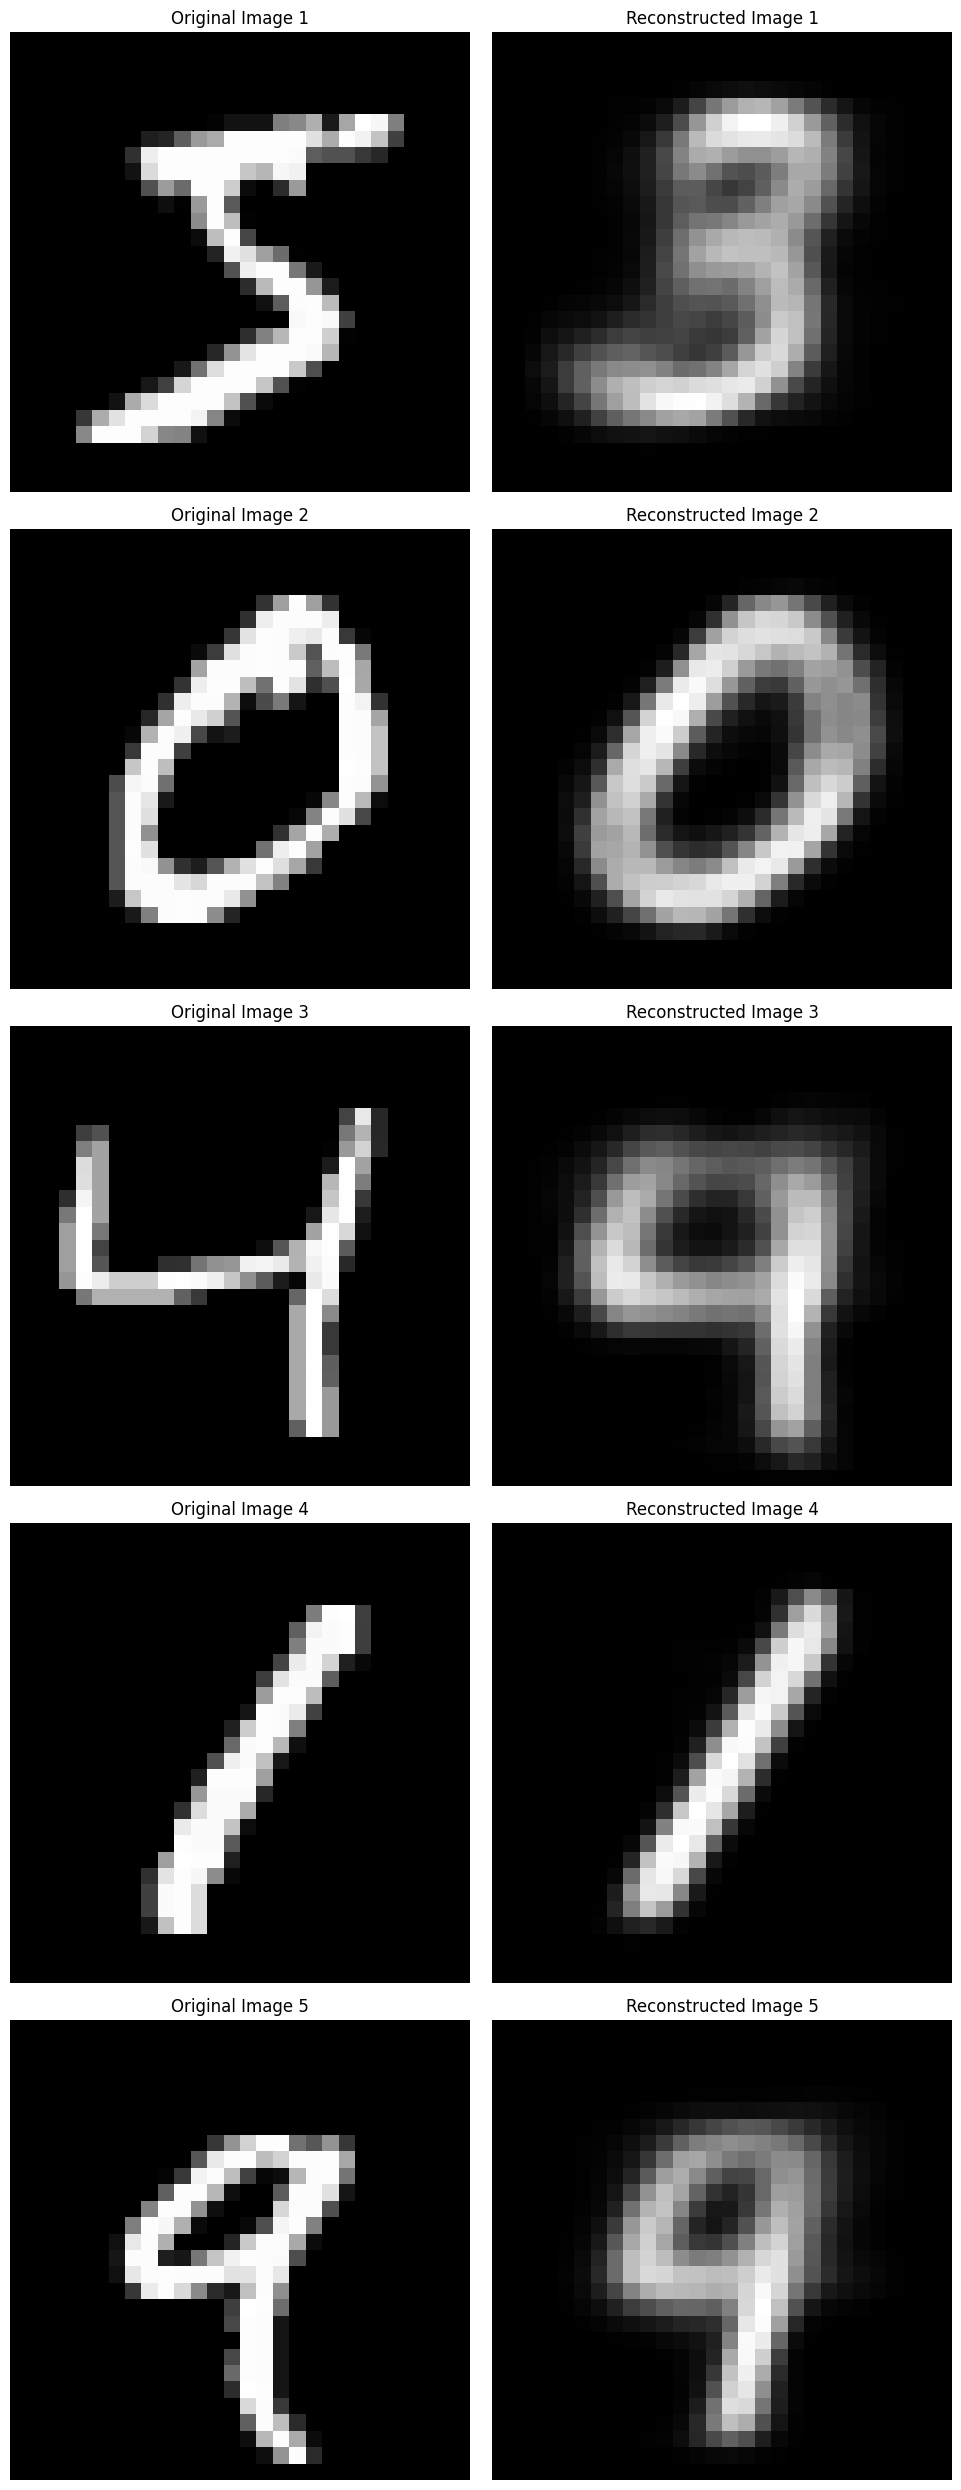

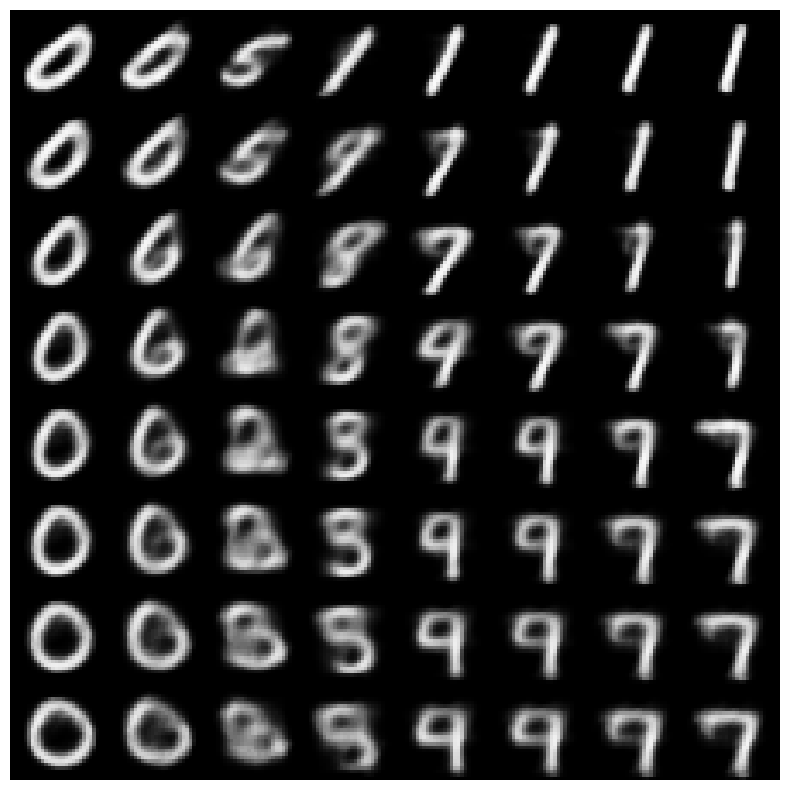

In [18]:
##################
### Problem 3(c): Evaluate VAE with analytical KL
eval(vae_kl_wo_e)
plot_latent_images(vae_kl_wo_e, n=8)
##################
